In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path(r"C:\Users\net pc\Desktop\Training Datsets")

In [3]:
filepaths = list(image_dir.glob(r'*/*.JPG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [4]:
image_df

,Filepath,Label
0,C:\Users\net pc\Desktop\Training Datsets\gliom...,glioma_tumors
1,C:\Users\net pc\Desktop\Training Datsets\gliom...,glioma_tumors
2,C:\Users\net pc\Desktop\Training Datsets\gliom...,glioma_tumors
3,C:\Users\net pc\Desktop\Training Datsets\gliom...,glioma_tumors
4,C:\Users\net pc\Desktop\Training Datsets\gliom...,glioma_tumors
...,...,...
9995,C:\Users\net pc\Desktop\Training Datsets\pitui...,pituitary_tumors
9996,C:\Users\net pc\Desktop\Training Datsets\pitui...,pituitary_tumors
9997,C:\Users\net pc\Desktop\Training Datsets\pitui...,pituitary_tumors
9998,C:\Users\net pc\Desktop\Training Datsets\pitui...,pituitary_tumors


In [5]:
train_df, test_df = train_test_split(image_df, train_size=0.80, shuffle=True, random_state=1)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:


train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2,
                                                                  validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [8]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                   x_col='Filepath',
                                                   y_col='Label',
                                                   target_size=(64, 64),
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=True,
                                                   seed=42,
                                                   subset='training')

val_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                 x_col='Filepath',
                                                 y_col='Label',
                                                 target_size=(64, 64),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=42,
                                                 subset='validation')

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='Filepath',
                                                 y_col='Label',
                                                 target_size=(64, 64),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=32,
                                                 shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.
Found 1600 validated image filenames belonging to 4 classes.
Found 2000 validated image filenames belonging to 4 classes.


In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Dropout, Flatten
from tensorflow.keras.layers import Dropout

ResNet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(64, 64, 3))


#ResNet = ResNet50(input_shape= (64, 64, 3), weights='imagenet', include_top=False)
ResNet.trainable = False

In [10]:
model = keras.Sequential([
    ResNet,
    keras.layers.Flatten(),
#    keras.layers.Dropout(0.5),
#    keras.layers.Dense(units=32, activation='relu'),
#    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=4, activation='softmax'),
])

In [11]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
for layer in model.layers:
    print(layer, layer.trainable)

<Functional name=resnet50, built=True> False
<Flatten name=flatten, built=False> True
<Dense name=dense, built=False> True


In [14]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/50


C:\Users\Public\Efendim\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 200ms/step - accuracy: 0.3463 - loss: 1.3371 - val_accuracy: 0.3819 - val_loss: 1.2826 - learning_rate: 0.0010
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 186ms/step - accuracy: 0.4342 - loss: 1.2397 - val_accuracy: 0.4769 - val_loss: 1.2237 - learning_rate: 0.0010
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 187ms/step - accuracy: 0.4642 - loss: 1.2047 - val_accuracy: 0.4913 - val_loss: 1.1750 - learning_rate: 0.0010
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.4741 - loss: 1.1984 - val_accuracy: 0.4975 - val_loss: 1.1538 - learning_rate: 0.0010
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 189ms/step - accuracy: 0.4875 - loss: 1.1678 - val_accuracy: 0.4675 - val_loss: 1.1763 - learning_rate: 0.0010
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - accuracy: 0.4964 - loss: 1.1654 - val_accuracy: 0.5119 - val_loss: 1.1541 - learning_rate: 0.0010
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - accuracy: 0.4970 - loss:

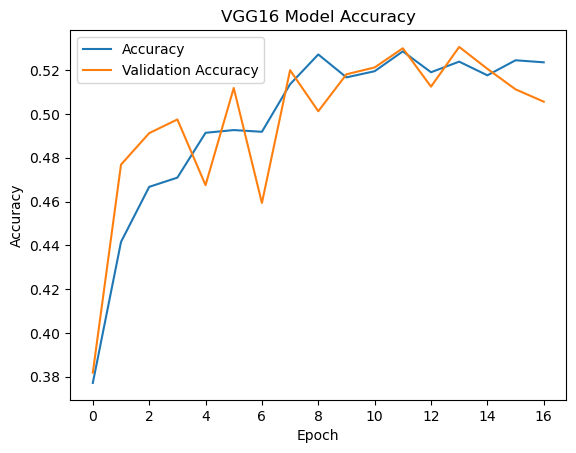

In [15]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(14, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy', 'loss', 'Validation Loss'])
plt.show()

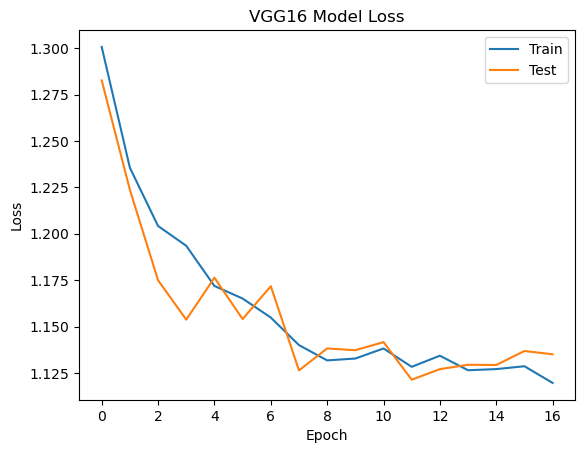

In [16]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(14, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [17]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.13928
Test Accuracy: 51.80%


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step


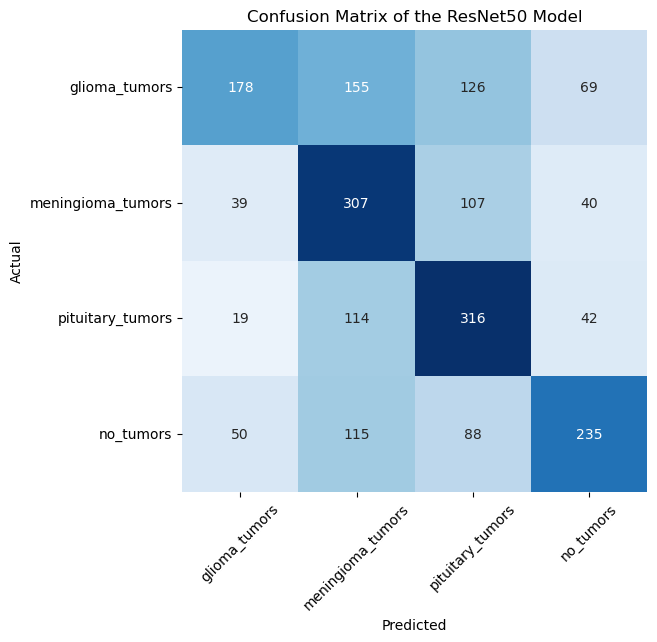

Classification Report:
----------------------
                    precision    recall  f1-score   support

    glioma_tumors       0.62      0.34      0.44       528
meningioma_tumors       0.44      0.62      0.52       493
 pituitary_tumors       0.50      0.64      0.56       491
        no_tumors       0.61      0.48      0.54       488

         accuracy                           0.52      2000
        macro avg       0.54      0.52      0.51      2000
     weighted avg       0.54      0.52      0.51      2000



In [18]:

# Convert labels to one-hot encoding
from keras.utils import to_categorical

test_labels_onehot = to_categorical(test_images.labels, num_classes=4)

# Predict classes
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(np.argmax(test_labels_onehot, axis=1), predicted_classes)

# Create classification report
clr = classification_report(np.argmax(test_labels_onehot, axis=1), predicted_classes, target_names=["glioma_tumors", "meningioma_tumors", "pituitary_tumors", "no_tumors"])

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=["glioma_tumors", "meningioma_tumors", "pituitary_tumors", "no_tumors"], rotation=45)
plt.yticks(ticks=np.arange(4) + 0.5, labels=["glioma_tumors", "meningioma_tumors", "pituitary_tumors", "no_tumors"], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of the ResNet50 Model")
plt.show()

# Print classification report
print("Classification Report:\n----------------------\n", clr)


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step


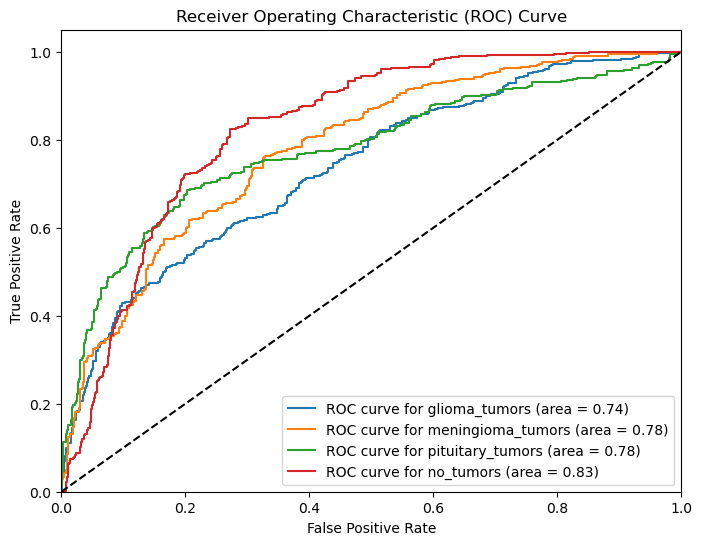

AUC ROC for glioma_tumors: 0.73627
AUC ROC for meningioma_tumors: 0.78119
AUC ROC for pituitary_tumors: 0.77625
AUC ROC for no_tumors: 0.82628


In [19]:
# Obtain predicted probabilities
predicted_probabilities = model.predict(test_images)

# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve

# Convert labels to one-hot encoding
from keras.utils import to_categorical
test_labels_onehot = to_categorical(test_images.labels, num_classes=4)

# Compute AUC ROC for each class
auc_roc = dict()
for i in range(4):
    auc_roc[i] = roc_auc_score(test_labels_onehot[:, i], predicted_probabilities[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(test_labels_onehot[:, i], predicted_probabilities[:, i])
    plt.plot(fpr, tpr, label='ROC curve for {} (area = {:.2f})'.format(["glioma_tumors", "meningioma_tumors", "pituitary_tumors", "no_tumors"][i], auc_roc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC ROC for each class
for i in range(4):
    print("AUC ROC for {}: {:.5f}".format(["glioma_tumors", "meningioma_tumors", "pituitary_tumors", "no_tumors"][i], auc_roc[i]))


In [20]:
# save the model to a file
#model.save('ResNet50-Brain Tumor vs Kidney tumor .h5')